In [60]:
# Initialize Otter
import otter
grader = otter.Notebook("covid_part1.ipynb")

# Final Project: COVID-19 Dataset
## Exploring COVID-19 Data through Modeling
## Due Date: Wednesday, November 17th, 11:59 PM
## Collaboration Policy

Data science is a collaborative activity. While you may talk with other groups about
the project, we ask that you **write your solutions within your own group**. If you do
discuss the assignments with others outside of your group please **include their names** at the top
of your notebook.


## This Assignment

In this final project, we will investigate COVID-19 data over the past year. This data contains information about COVID-19 case counts, mortalities, vaccination rates, and various other metadata that can assist in modeling various aspects of COVID-19.

Through this final project, you will demonstrate your experience with:
* Data cleaning and EDA using Pandas
* Unsupervised and supervised learning techniques
* Visualization


## Goal

Model and analyze the temporal evolution of COVID-19 mortalities or cases using one unsupervised and one supervised technique of your choice. Interpret your models' results through visualizations, and draw insightful conclusions about the modeling of COVID-19 data.

Recall that we studied linear and logistic regression, decision trees, random forests as part of supervised learning (with labels) and clustering, PCA as part of unsupervised learning (without labels). You are free to use any methods that you find suitable to answer the problem at hand.

In [61]:
# Run this cell to set up your notebook
import numpy as np
from geopy import *
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.cluster import *
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from scipy.stats import pearsonr
import re

cases = pd.read_csv('data/time_series_covid19_confirmed_US.csv') # https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv
vaccinations = pd.read_csv('data/people_vaccinated_us_timeline.csv') # https://raw.githubusercontent.com/govex/COVID-19/master/data_tables/vaccine_data/us_data/time_series/people_vaccinated_us_timeline.csv
counties = pd.read_csv('data/co-est2020.csv', encoding='latin-1') # https://www2.census.gov/programs-surveys/popest/datasets/2010-2020/counties/totals/co-est2020.csv
mask_use = pd.read_csv('data/mask-use-by-county.csv') # https://github.com/nytimes/covid-19-data/blob/master/mask-use/mask-use-by-county.csv

<br/><br/><br/>

---

<br/><br/><br/>

## Question 0: Basic Time Series Modeling

We will introduce a few basic modeling techniques using temporally correlated data that you are free to adapt or improve throughout your modeling process if you wish. Answer these questions in their respective cells below.

### Question 0a
Suppose $\tilde{x} = [1, x_{t}]$ represents the input to a machine learning function $f_\theta: \mathbb{R}^{2} \rightarrow \mathbb{R}$, and we wish to predict $x_{t + 1}$ such that $f_\theta(\tilde{x}) \approx x_{t+1}$. You may assume that $t = 0$ corresponds to the start of time. 

<!-- BEGIN QUESTION -->

i) Is this an example of supervised or unsupervised learning?
<!--
BEGIN QUESTION
name: q0ai
points: 2
manual: True
-->

This is supervised learning because it is similar to regression. We are predicting one value by mapping multiple features.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

ii) Write the function $x_{t+1}$ explicitly in terms of the model parameters $\theta = [\theta_0, \theta_1]$ and $x_t$ assuming $f$ represents a linear model.
<!--
BEGIN QUESTION
name: q0aii
points: 2
manual: True
-->

$x_{t+1} =\theta_0 + \theta_1*x_t$

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

iii) Suppose we obtain an optimal $\hat{\theta} = [\hat{\theta}_0, \hat{\theta}_1]$. Derive $x_{t+1}$ in terms of $x_0$, $\hat{\theta}_0$ and $\hat{\theta}_1$.

<!--
BEGIN QUESTION
name: q0aiii
points: 4
manual: True
-->

$x_{t+1} =\hat\theta_0 + \hat\theta_1*x_0$

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

iv) Suppose we add $k - 1$ more features such that our feature vector $\tilde{x}$ contains $k$ timesteps of past and current data. Describe how we could select an appropriate $k$.

<!--
BEGIN QUESTION
name: q0aiv
points: 2
manual: True
-->

We could select an appropriate k by utilizing cross-validation to find an appropriate balance between over- and under- fitting.

<!-- END QUESTION -->



<br/><br/><br/>

---

<br/><br/><br/>

## Question 1: Data Cleaning

### Question 1a

Investigate the number of missing or null values in `cases` and `vaccinations`. Which one column contains the *most* null values from both of these tables?

<!--
BEGIN QUESTION
name: q1a
points: 2
-->

In [62]:
vax_null = vaccinations.isnull().sum()
vax_null

cases_null = cases.isnull().sum()
cases_null

most_null_value_col = "People_Partially_Vaccinated"

In [63]:
grader.check("q1a")

q1a results: All test cases passed!

### Question 1b

Impute the null values in *all* the datasets with zero values or empty strings where appropriate.

<!--
BEGIN QUESTION
name: q1b
points: 2
-->

In [64]:
for df in [cases, vaccinations, counties, mask_use]:
    for i in list(df):
        if df.dtypes[i] == 'int64' or df.dtypes[i] == 'float64':
            df[i] = df[i].fillna(0)
        if df.dtypes[i] == 'object':
            df[i] = df[i].fillna("")



In [65]:
grader.check("q1b")

q1b results: All test cases passed!

### Question 1c

Add a column to `cases` named `median_increase` that describes the median daily increase in the number of cases over the time period January 23, 2020 to September 12, 2021. In other words, calculate the increase in cases day-to-day from January 22nd to 23rd, 23rd to 24th, 24th to 25th, and so on; then, find the median of the number of increase in cases over that time period for all counties.

*Hint*: Try not to use a `for` loop.

<!--
BEGIN QUESTION
name: q1c
points: 2
-->

In [66]:
temp = cases.loc[:, "1/22/20":"9/12/21"]
diffs = np.diff(temp, axis = 1)
cases["median_increase"] = [np.median(i) for i in diffs]
cases

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,9/4/21,9/5/21,9/6/21,9/7/21,9/8/21,9/9/21,9/10/21,9/11/21,9/12/21,median_increase
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,...,8959,9012,9048,9063,9108,9145,9207,9246,9287,10.0
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,...,33968,34063,34142,34246,34393,34536,34726,34872,34950,24.0
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,...,3166,3184,3197,3207,3225,3243,3260,3282,3295,3.0
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,...,3618,3628,3641,3661,3694,3727,3752,3778,3795,3.0
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,...,8830,8862,8899,8951,8998,9048,9095,9161,9176,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3337,84056039,US,USA,840,56039.0,Teton,Wyoming,US,43.935225,-110.589080,...,4502,4502,4502,4568,4572,4587,4611,4611,4611,2.0
3338,84056041,US,USA,840,56041.0,Uinta,Wyoming,US,41.287818,-110.547578,...,3053,3053,3053,3086,3141,3168,3204,3204,3204,1.0
3339,84090056,US,USA,840,90056.0,Unassigned,Wyoming,US,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0.0
3340,84056043,US,USA,840,56043.0,Washakie,Wyoming,US,43.904516,-107.680187,...,1080,1080,1080,1087,1104,1111,1120,1120,1120,0.0


In [67]:
grader.check("q1c")

q1c results: All test cases passed!

### Question 1d

Generate a valid FIPS code for the `counties` table.

*Hint*: Refer to [this](https://transition.fcc.gov/oet/info/maps/census/fips/fips.txt) guide on FIPS codes.

<!--
BEGIN QUESTION
name: q1d
points: 2
-->

In [68]:
counties["FIPS"] = counties["STATE"]*1000 + counties["COUNTY"]
counties

,SUMLEV,REGION,DIVISION,STATE,COUNTY,STNAME,CTYNAME,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,...,POPESTIMATE2013,POPESTIMATE2014,POPESTIMATE2015,POPESTIMATE2016,POPESTIMATE2017,POPESTIMATE2018,POPESTIMATE2019,POPESTIMATE042020,POPESTIMATE2020,FIPS
0,40,3,6,1,0,Alabama,Alabama,4779736,4780118,4785514,...,4831586,4843737,4854803,4866824,4877989,4891628,4907965,4920706,4921532,1000
1,50,3,6,1,1,Alabama,Autauga County,54571,54582,54761,...,54747,54922,54903,55302,55448,55533,55769,56130,56145,1001
2,50,3,6,1,3,Alabama,Baldwin County,182265,182263,183121,...,194978,199306,203101,207787,212737,218071,223565,227989,229287,1003
3,50,3,6,1,5,Alabama,Barbour County,27457,27454,27325,...,26946,26768,26300,25828,25169,24887,24657,24652,24589,1005
4,50,3,6,1,7,Alabama,Bibb County,22915,22904,22858,...,22510,22541,22553,22590,22532,22300,22313,22199,22136,1007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3189,50,4,8,56,37,Wyoming,Sweetwater County,43806,43806,43580,...,45189,44996,44780,44319,43663,43188,42917,42717,42673,56037
3190,50,4,8,56,39,Wyoming,Teton County,21294,21298,21298,...,22335,22801,23083,23255,23383,23261,23385,23453,23497,56039
3191,50,4,8,56,41,Wyoming,Uinta County,21118,21121,21090,...,20969,20835,20777,20711,20449,20299,20196,20169,20215,56041
3192,50,4,8,56,43,Wyoming,Washakie County,8533,8528,8531,...,8417,8277,8282,8180,8013,7886,7824,7756,7760,56043


In [69]:
grader.check("q1d")

q1d results: All test cases passed!

### Question 1e

Merge the `counties`, `cases`, and `mask_use` tables on an appropriate primary key to generate county-wise data.

<!--
BEGIN QUESTION
name: q1e
points: 2
-->

In [70]:
mid = counties.merge(right = cases, how = "inner", left_on = "FIPS", right_on = "FIPS")
county_data = mid.merge(right = mask_use, how = "inner", left_on = "FIPS", right_on = "COUNTYFP")
county_data


,SUMLEV,REGION,DIVISION,STATE,COUNTY,STNAME,CTYNAME,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,...,9/10/21,9/11/21,9/12/21,median_increase,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
0,50,3,6,1,1,Alabama,Autauga County,54571,54582,54761,...,9207,9246,9287,10.0,1001,0.053,0.074,0.134,0.295,0.444
1,50,3,6,1,3,Alabama,Baldwin County,182265,182263,183121,...,34726,34872,34950,24.0,1003,0.083,0.059,0.098,0.323,0.436
2,50,3,6,1,5,Alabama,Barbour County,27457,27454,27325,...,3260,3282,3295,3.0,1005,0.067,0.121,0.120,0.201,0.491
3,50,3,6,1,7,Alabama,Bibb County,22915,22904,22858,...,3752,3778,3795,3.0,1007,0.020,0.034,0.096,0.278,0.572
4,50,3,6,1,9,Alabama,Blount County,57322,57322,57372,...,9095,9161,9176,8.0,1009,0.053,0.114,0.180,0.194,0.459
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3136,50,4,8,56,37,Wyoming,Sweetwater County,43806,43806,43580,...,6111,6111,6111,3.0,56037,0.061,0.295,0.230,0.146,0.268
3137,50,4,8,56,39,Wyoming,Teton County,21294,21298,21298,...,4611,4611,4611,2.0,56039,0.095,0.157,0.160,0.247,0.340
3138,50,4,8,56,41,Wyoming,Uinta County,21118,21121,21090,...,3204,3204,3204,1.0,56041,0.098,0.278,0.154,0.207,0.264
3139,50,4,8,56,43,Wyoming,Washakie County,8533,8528,8531,...,1120,1120,1120,0.0,56043,0.204,0.155,0.069,0.285,0.287


In [71]:
grader.check("q1e")

q1e results: All test cases passed!

<!-- BEGIN QUESTION -->

### Question 1f

Generate the population by state using `counties` using the population estimate in 2020 (i.e. `POPESTIMATE2020`). Remark on any inconsistencies and propose a solution. 
<!--
BEGIN QUESTION
name: q1f
points: 2
manual: True
-->

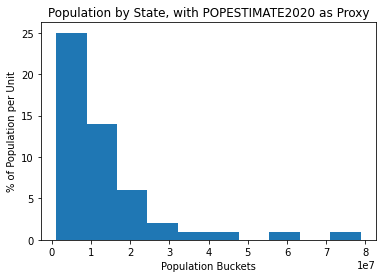

In [72]:
plt.hist(counties[["POPESTIMATE2020", "STNAME"]].groupby("STNAME").sum())
plt.title("Population by State, with POPESTIMATE2020 as Proxy")
plt.ylabel("% of Population per Unit")
plt.xlabel("Population Buckets");

After generating a histogram plot of 2020 population estimate per state, it appears the data is skewed right. Thus, we can take the log of the numbers to make the distribution more normal.

<!-- END QUESTION -->



<br/><br/><br/>

---

<br/><br/><br/>

## Question 2: Guided EDA

<!-- BEGIN QUESTION -->

### Question 2a

Create a visualization that shows the median increase in number of cases for the 50 counties with the greatest median increase over January 23, 2020 to September 12, 2021. Make sure to include the name of state in which each county is located since county names are not necessarily unique.
<!--
BEGIN QUESTION
name: q2a
points: 3
manual: True
-->

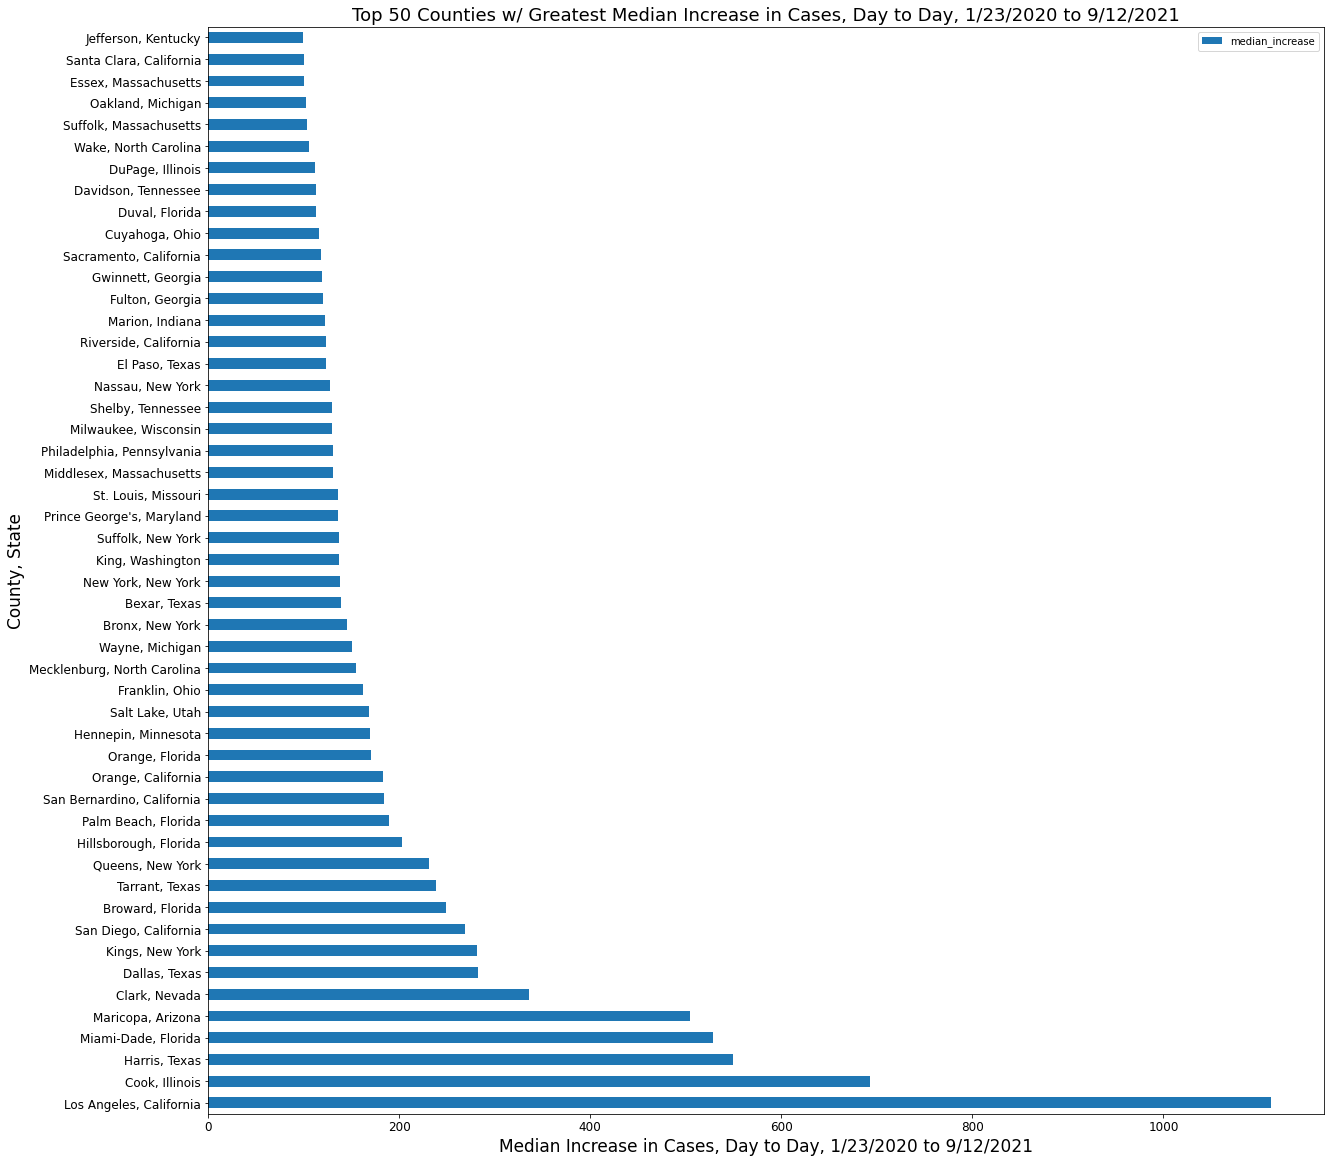

In [73]:
increases = cases.loc[:, "1/23/20":"9/12/21"]
increases["median_increase"] = [np.median(i) for i in np.diff(increases, axis = 1)]
increases["County & State"] = cases["Admin2"] + ", " + cases["Province_State"]
top_50 = increases.sort_values("median_increase", ascending = False).head(50)[["County & State", "median_increase"]]

top_50.plot.barh(x = "County & State", y = "median_increase", rot = 0, fontsize = 12, figsize = (20,20))
plt.xlabel("Median Increase in Cases, Day to Day, 1/23/2020 to 9/12/2021", fontsize = 17)
plt.ylabel("County, State", fontsize = 17)
plt.title("Top 50 Counties w/ Greatest Median Increase in Cases, Day to Day, 1/23/2020 to 9/12/2021", fontsize = 18);

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 2b

Create a visualization that shows the overall county-wise distribution of the number of COVID-19 cases per capita across the United States as a function of time. For all questions that reference population, use the population estimates from 2020.
<!--
BEGIN QUESTION
name: q2b
points: 4
manual: True
-->

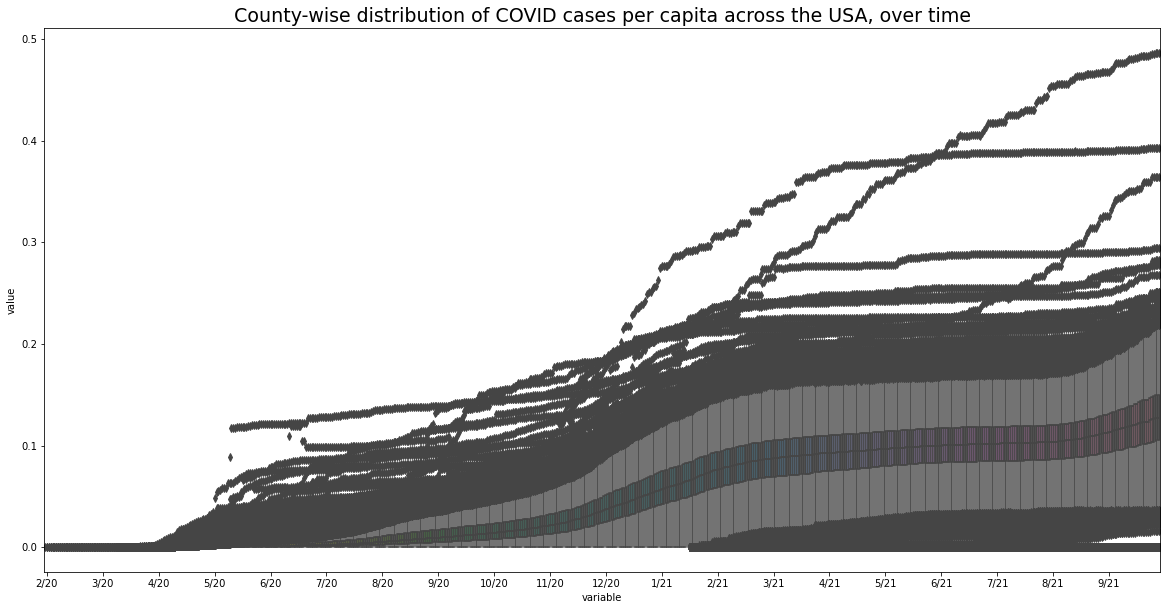

In [74]:
timeline_per_capita = county_data.loc[:, "1/23/20":"9/12/21"]
for i in list(timeline_per_capita):
    timeline_per_capita[i] = timeline_per_capita[i]/county_data["POPESTIMATE2020"]
plt.figure(figsize=(20,10))
sns.boxplot(x = "variable", y = "value", data = pd.melt(timeline_per_capita))
plt.xticks(ticks = range(1, 600, 30), labels = ["2/20","3/20","4/20","5/20","6/20","7/20","8/20","9/20","10/20","11/20","12/20","1/21","2/21","3/21","4/21","5/21",
           "6/21","7/21","8/21","9/21"])
plt.title("County-wise distribution of COVID cases per capita across the USA, over time", fontsize = 19);

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 2c

Create a visualization that shows states' increases in the number of COVID-19 cases per capita from September 3rd to September 12th, sorted from least to greatest increases. 

<!--
BEGIN QUESTION
name: q2c
points: 3
manual: True
-->

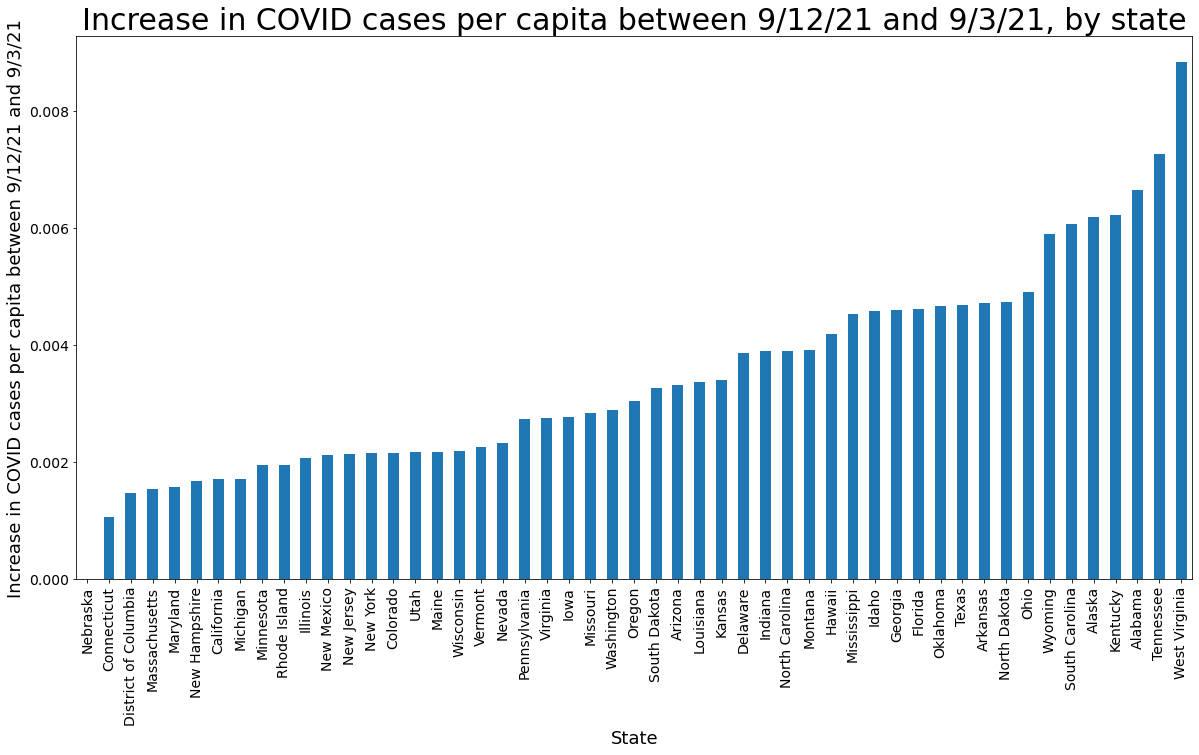

In [75]:
states = county_data.loc[:, "1/23/20":"9/12/21"]
states["State"] = county_data["STNAME"]
states["Population"] = county_data["POPESTIMATE2020"]
states = states.groupby("State").sum()
for i in list(states):
    states[i] = states[i]/states["Population"]
states_diffs = data = states["9/12/21"] - states["9/3/21"]
states_diffs = data = states_diffs.sort_values(ascending = True)
states_diffs.plot.bar(rot = 90, fontsize = 14, figsize = (20,10))
plt.xlabel("State", fontsize = 18)
plt.ylabel("Increase in COVID cases per capita between 9/12/21 and 9/3/21", fontsize = 18)
plt.title("Increase in COVID cases per capita between 9/12/21 and 9/3/21, by state", fontsize = 30);


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 2d

Create a plot using a technique of your choice that visualizes the relationship between:

a) the number of COVID-19 cases as a function of time for the Mobile, Tarrant, Cook, and San Fransisco counties located in Alabama, Texas, Illinois, and California.

b) the frequency of never, rarely or sometimes wearing a mask in the respective counties

*Hint*: You may find a description of the data [here](https://github.com/CSSEGISandData/COVID-19/blob/846fa9458cc2a8904d2492d14d3e6b4f399ec027/csse_covid_19_data/csse_covid_19_time_series/README.md).

<!--
BEGIN QUESTION
name: q2d
points: 3
manual: True
-->

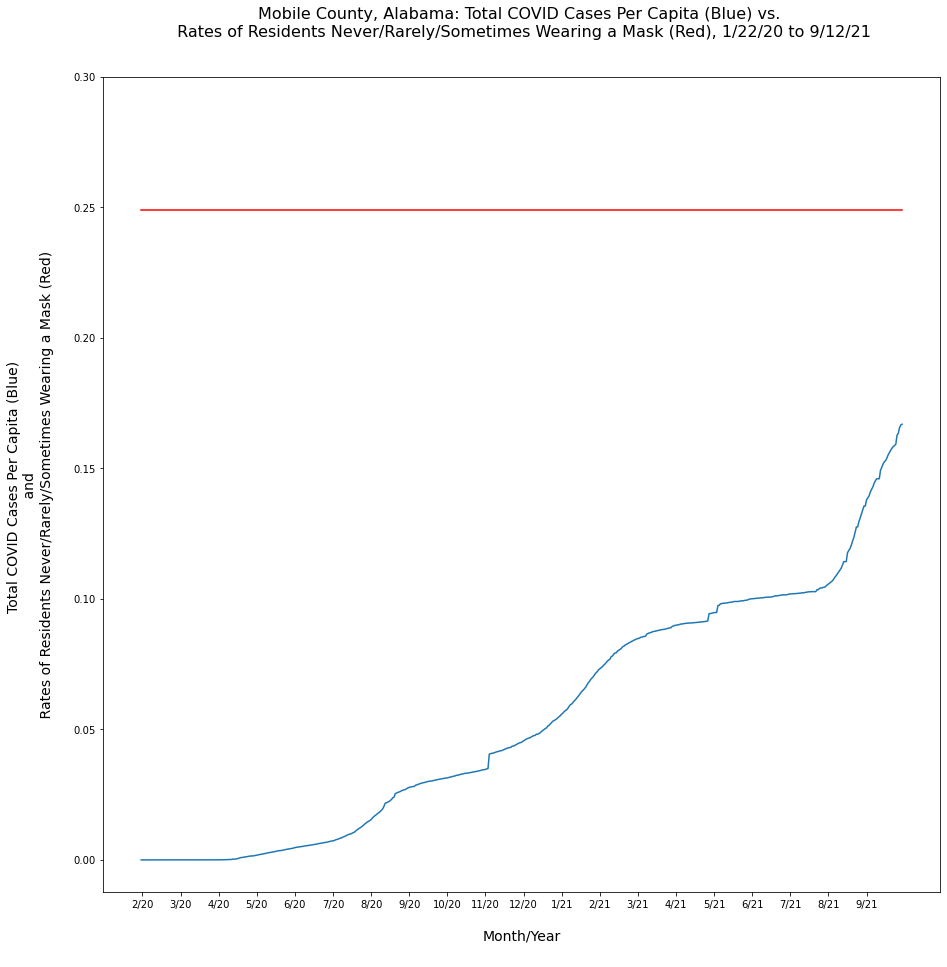

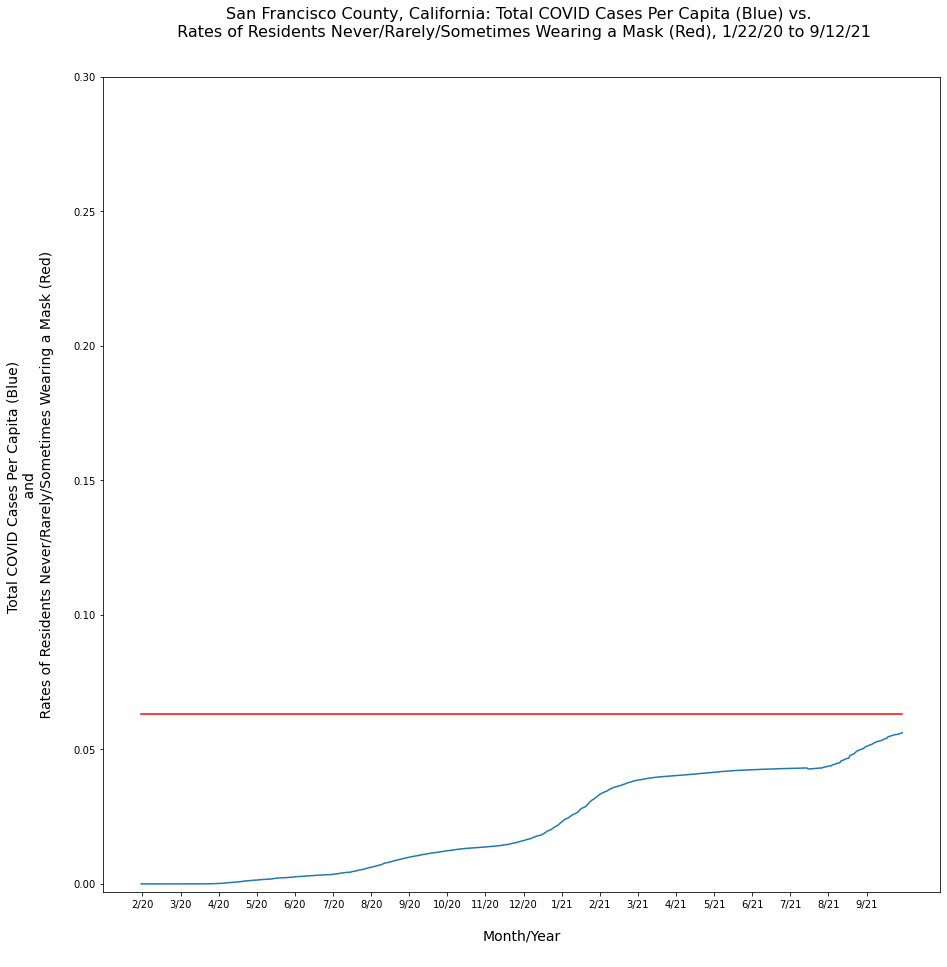

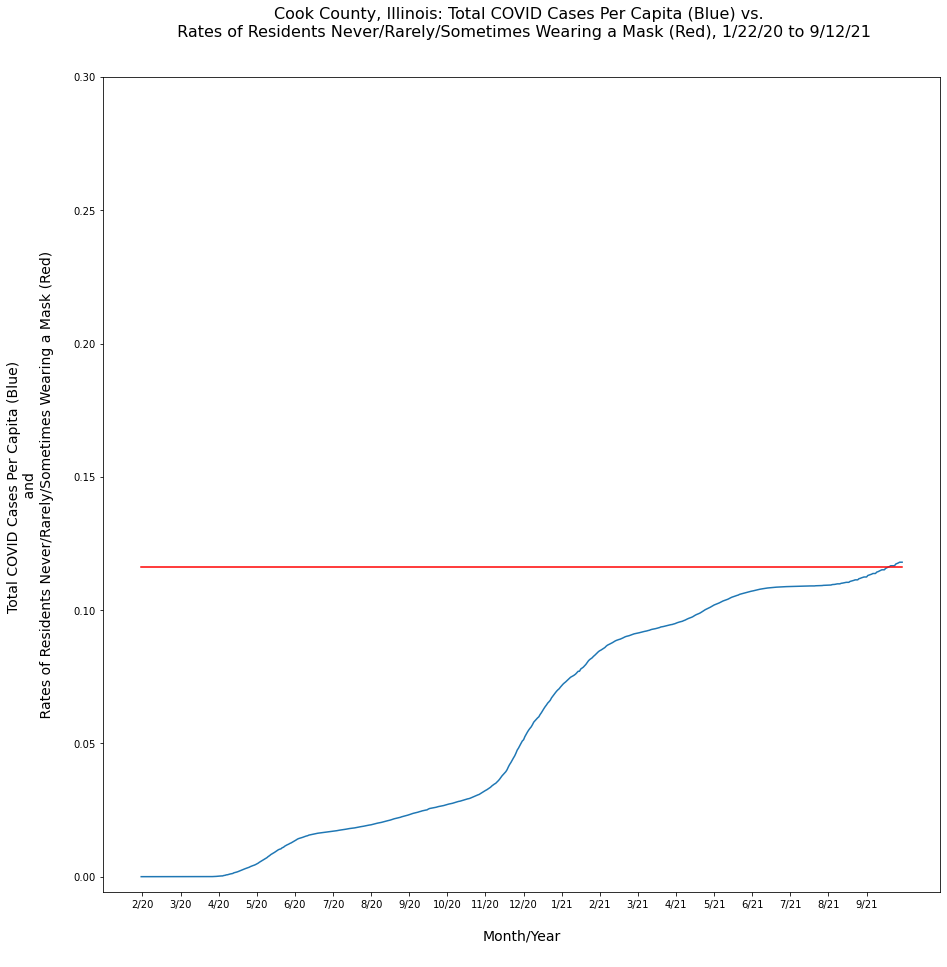

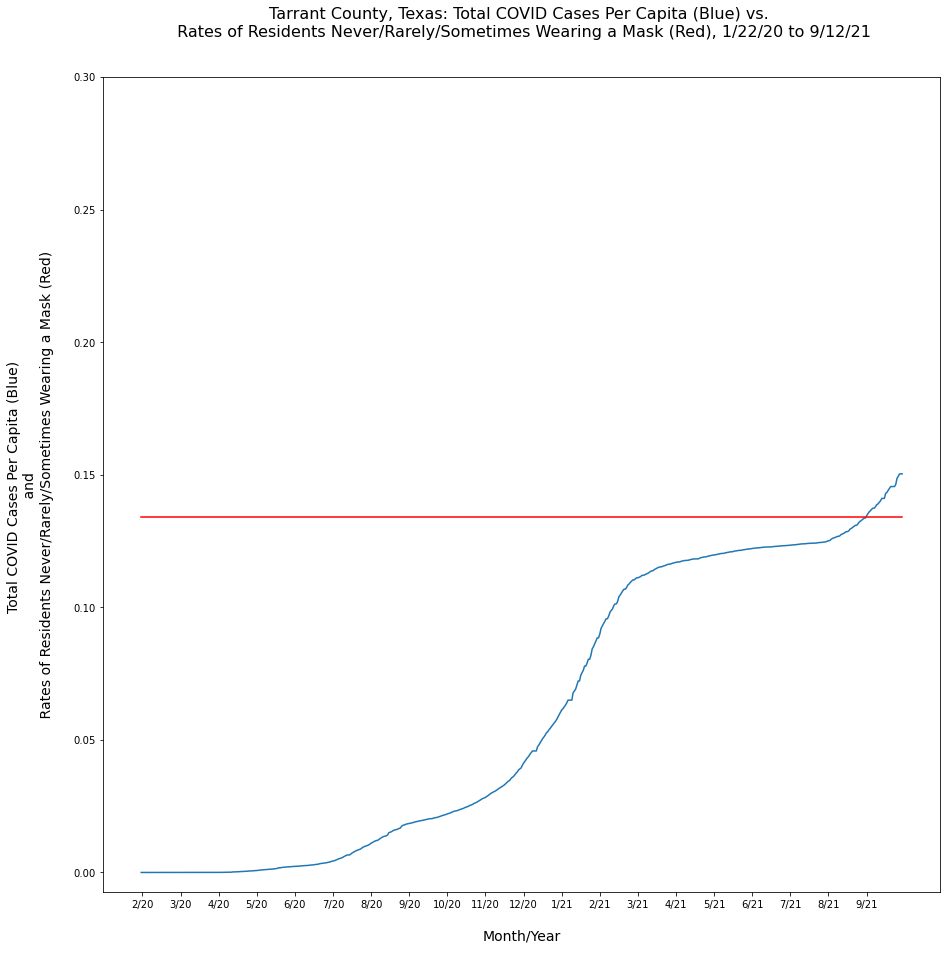

In [76]:
four = county_data[(county_data["CTYNAME"] == "Mobile County") | (county_data["CTYNAME"] == "Tarrant County") | 
                   (county_data["CTYNAME"] == "Cook County") | (county_data["CTYNAME"] == "San Francisco County")]
four = four[four["STNAME"].isin(["Alabama", "Texas", "Illinois", "California"])]
final_four = four.loc[:, "1/22/20":"9/12/21"]
final_four["Population"] = four["POPESTIMATE2020"]
final_four["CTYNAME + STNAME"] = four["CTYNAME"] + ", " + four["STNAME"]
final_four["Never/Rarely/Sometimes Wearing a Mask"] = four["NEVER"] + four["RARELY"] + four["SOMETIMES"]
final_four = final_four.set_index("CTYNAME + STNAME")
final_four
for i in list(final_four)[:-2]:
    final_four[i] = final_four[i]/final_four["Population"]

for i in final_four.index:
    
    fig, ax = plt.subplots(figsize=(15,15))
    x = pd.DataFrame(data = final_four.loc[i, "1/22/20":"9/12/21"])
    
    ax.plot(x)
    ax.plot([final_four.loc[i, "Never/Rarely/Sometimes Wearing a Mask"] for n in range(x.shape[0])], color = "red")
    plt.xticks(ticks = range(1, 600, 30), labels = ["2/20","3/20","4/20","5/20","6/20","7/20","8/20","9/20","10/20","11/20","12/20","1/21","2/21","3/21","4/21","5/21",
           "6/21","7/21","8/21","9/21"])
    plt.yticks([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3])
    plt.ylabel("Total COVID Cases Per Capita (Blue) \n and \n Rates of Residents Never/Rarely/Sometimes Wearing a Mask (Red) \n", fontsize = 14)
    
    
    
    
    plt.title(i + ": Total COVID Cases Per Capita (Blue) vs. \n Rates of Residents Never/Rarely/Sometimes Wearing a Mask (Red), 1/22/20 to 9/12/21\n\n", fontsize = 16)
    plt.xlabel("\nMonth/Year\n", fontsize = 14)
    
    


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 2e

Visualize and describe the spatial relationship between the location and the following quantities over the continguous United States:

a) the number of most recent COVID-19 cases per capita on September 12, 2021

b) the frequency of never, rarely or sometimes wearing a mask

*Hint*: Use `plotly` to generate a heatmap on a geographical plot of the United States!

<!--
BEGIN QUESTION
name: q2e
points: 5
manual: True
-->

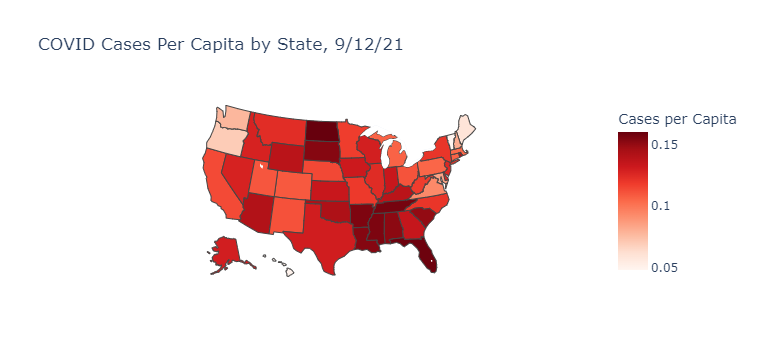

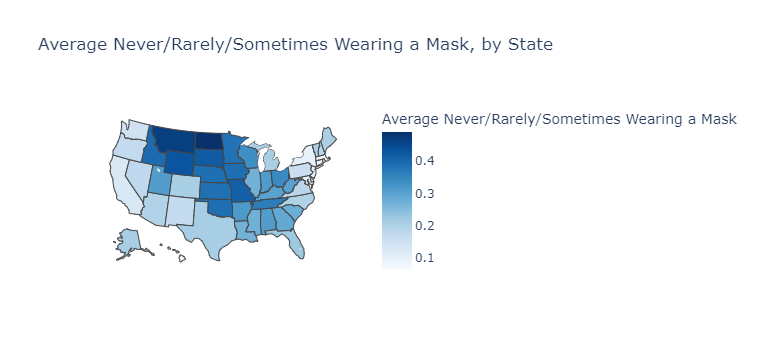

In [77]:
grouped = county_data.groupby("STNAME").sum()
#grouped = grouped[(grouped.index != "Hawaii") & (grouped.index != "Alaska")]
grouped["Cases per Capita"] = grouped["9/12/21"] / grouped["POPESTIMATE2020"]
grouped = grouped[["Cases per Capita"]]


mask_usage = county_data.groupby("STNAME").mean()
mask_usage["Average Never/Rarely/Sometimes Wearing a Mask"] = mask_usage["NEVER"] + mask_usage["RARELY"] + mask_usage["SOMETIMES"]
mask_usage = mask_usage[["Average Never/Rarely/Sometimes Wearing a Mask"]]
mask_usage

joined = grouped.merge(mask_usage, how = "inner", left_on = "STNAME", right_on = "STNAME")
joined = joined.reset_index()

joined = joined.replace({
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC"})



import plotly.graph_objects as go



fig = go.Figure(data=go.Choropleth(
    locations=joined["STNAME"], 
    z = joined["Cases per Capita"].astype(float), 
    locationmode = 'USA-states', 
    colorscale = 'Reds',
    colorbar_title = "Cases per Capita"
))

fig.update_layout(
    title_text = 'COVID Cases Per Capita by State, 9/12/21',
    geo_scope='usa'
)

fig.show()



fig2 = go.Figure(data=go.Choropleth(
    locations=joined["STNAME"], 
    z = joined["Average Never/Rarely/Sometimes Wearing a Mask"].astype(float),
    locationmode = 'USA-states', 
    colorscale = 'Blues',
    colorbar_title = "Average Never/Rarely/Sometimes Wearing a Mask"
))

fig2.update_layout(
    title_text = 'Average Never/Rarely/Sometimes Wearing a Mask, by State',
    geo_scope='usa', 
)

fig2.show()


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 2f

Describe and interpret the relationships in the plots above. What conclusions can be drawn about the COVID-19 dataset from these plots?

<!--
BEGIN QUESTION
name: q2f
points: 3
manual: True
-->

Based on the group of plots as a whole, there are a few prevalent trends that can be extracted. The first is that mask usage is negatively associated with the spread of COVID. There are a few pieces of evidence for this. First, based on 2d, states with high rates of residents who never, rarely, or sometimes wear a mask generally had higher growth rates of cases. Additionally, based on the geoplots in 2e, states with less mask usage tended to also have a higher amount of cases per capita on 9/12/21; the converse appears to be true as well.

Additionally, from a broader perspective, some counties have much more cases than others. The county with the largest amount of median cases (LA County) had almost 1.7x the same figure for the county with the second largest figure (Cook County, Illinois), providing insight into the shape and distribution of the dataset.

Finally, in accordance with patterns reported in new outlets, there are certain periods where cases per capita across the USA were stagnant, and other periods where they spiked significantly. For instance, between November 2020 and February 2021, there was a steady increase in cases per capita, as illustrated by 2b. On the other hand, based on the same plot, there was a period from March 2021 to August 2021 in which cases per capita didn't rise significantly.

<!-- END QUESTION -->



<br/><br/><br/>

---

<br/><br/><br/>

## Question 3: Guided Unsupervised Exploration


<!-- BEGIN QUESTION -->

### Question 3a

Using SVD, decompose the standardized matrix $X$ that contains the standardized current proportion of fully vaccinated and partially vaccinated, cases per capita, and mask usage for every state as of the most recent day in the data.

*Hint*: The matrix $X$ should have rows that describe location.

<!--
BEGIN QUESTION
name: q3a
points: 3
manual: True
-->

In [78]:

recent = vaccinations.sort_values("Date", ascending = False)["Date"].iloc[900]

state_mask = pd.DataFrame(data = county_data).groupby("STNAME").mean()
state_mask = state_mask[["NEVER", "RARELY", "SOMETIMES", "FREQUENTLY", "ALWAYS"]]




mask_and_vax = vaccinations.merge(state_mask, how = "inner", left_on = "Province_State", right_on = "STNAME")
mask_and_vax = mask_and_vax[mask_and_vax["Date"] == recent]
mask_and_vax = mask_and_vax.groupby("Province_State").mean()



state_pops = county_data.groupby("STNAME").sum()[["POPESTIMATE2020"]].reset_index()

mask_and_vax = state_pops.merge(mask_and_vax, how = "inner", left_on = "STNAME", right_on = "Province_State")
state_cases = county_data.groupby("STNAME").sum()[["9/12/21"]].reset_index()
mask_and_vax_ag = state_cases.merge(mask_and_vax, how = "inner", left_on = "STNAME", right_on = "STNAME")

mask_and_vax_ag["Proportion Fully Vaccinated"] = mask_and_vax_ag["People_Fully_Vaccinated"]
mask_and_vax_ag["Proportion Fully Vaccinated"] = mask_and_vax_ag["Proportion Fully Vaccinated"].div(mask_and_vax_ag["POPESTIMATE2020"])
mask_and_vax_ag["Cases per Capita"] = mask_and_vax_ag["9/12/21"]
mask_and_vax_ag["Cases per Capita"] = mask_and_vax_ag["Cases per Capita"]/mask_and_vax_ag["POPESTIMATE2020"]
mask_and_vax_ag["Proportion Partially Vaccinated"] = mask_and_vax_ag["People_Partially_Vaccinated"]
mask_and_vax_ag["Proportion Partially Vaccinated"] = mask_and_vax_ag["Proportion Partially Vaccinated"].div(mask_and_vax_ag["POPESTIMATE2020"])



X = mask_and_vax_ag[["STNAME", "Proportion Fully Vaccinated", "Proportion Partially Vaccinated", "Cases per Capita", "NEVER", "RARELY", "SOMETIMES", "FREQUENTLY", "ALWAYS"]].set_index("STNAME")


X_mean = np.mean(X, axis = 0)
X_std = np.std(X, axis = 0)
X = (X - X_mean)/X_std


u, s, vt = np.linalg.svd(X, full_matrices = False)

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 3b

Visualize the top 2 principal components and label the data points with the corresponding location. Color each data points based on the number of cases per capita in the location to which it corresponds.

<!--
BEGIN QUESTION
name: q3b
points: 3
manual: True
-->

In [79]:
import plotly.express as px

top2 = pd.DataFrame(data = u * s).loc[:, :1]
top2.rename(columns = {0:"pc1", 1:"pc2"}, inplace = True)
top2 = top2.reset_index().join(mask_and_vax)[["pc1", "pc2", "STNAME", "Cases per Capita"]]
top2



fig = px.scatter(top2, x="pc1", y="pc2", text="STNAME", color = "Cases per Capita"); 

fig.update_traces(textposition='top center');

fig.show(); 

KeyError: "['Cases per Capita'] not in index"

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 3c

What could the first and second principal component roughly represent? Interpret the visualization above and report any findings from the first two principal components given by PCA.

<!--
BEGIN QUESTION
name: q3c
points: 3
manual: True
-->

The first PC could represent mask usage. It appears that data points with low PC1 values correspond to states with low mask usage, and vice versa. For instance, according to analysis in previous questions, Hawaii is the state that masks the most, and North Dakota the least.

The second PC could represent cases per capita within each subgroup of PC1 - i.e. within each subgroup of low and high mask usage. Within each of these two groups, a high PC2 would indicate a relatively low level of cases, and a low PC2 would indicate a relatively higher one. For instance, Maine has high PC2 and low cases per capita while Alabama and Florida have low PC2 but very high cases per capita.

It's important to note that the plot suggests the insight provided by PC2 is influenced by PC1. For instance, Alabama and Pennsylvania have comparable PC2's, but since they have significantly different PC1s, they have different amounts of cases per capita.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 3d

Construct a scree plot displaying the proportion of variance captured by each principal component.

<!--
BEGIN QUESTION
name: q3d
points: 3
manual: True
-->

In [ ]:
#pcs = pd.DataFrame(data = u * s)
#pcs.rename(columns = {0:"pc1", 1:"pc2", 2: "pc3", 3: "pc4", 4: "pc5", 5: "pc6", 6: "pc7", 7: "pc8"}, inplace = True)
#pcs

plt.plot(range(1, 9), s**2 / sum(s**2));
plt.xlabel('PC #');
plt.ylabel('Fraction of Variance Explained');
plt.title('Fraction of Variance Explained by each Principal Component');

<!-- END QUESTION -->

### Question 3e

Using the 2D representation of each state's first two principal components $x_i = [\text{PC}_1, \text{PC}_2]$, find each state's 5 closest principal component neighbors using Euclidean distance as the metric. In other words, for each state $i$ with first two principal components $x_i$, the following would be its *closest* principal component neighbor:

$$
\arg \min_{j \ne i} ||x_j - x_i||_2
$$

Store each state's 5 closest neighbors in a Pandas DataFrame, where the index is the state's name and the columns are the 5 closest PC neighbors.

<!--
BEGIN QUESTION
name: q3e
points: 3
-->

In [ ]:
top2_3e = top2[["pc1", "pc2"]]
top2_3e = top2_3e.join(mask_and_vax)[["pc1", "pc2", "STNAME"]]
top2_3e

pre_state_mins = pd.DataFrame(columns = ["State", "Closest", "#2", "#3", "#4", "#5"])
#pre_state_mins = pre_state_mins.append({"State": "a", "Closest": "a", "#2": "a", "#3": "a", "#4": "a", "#5": "a"}, ignore_index = True)

for i in range(top2_3e.shape[0]):
    dist = np.array(float)
    st = np.array(object)
    for j in range(top2_3e.shape[0]):
        dist = np.append(dist, ((top2_3e.loc[i, "pc1"] - top2_3e.loc[j, "pc1"])**2 + (top2_3e.loc[i, "pc2"] - top2_3e.loc[j, "pc2"])**2)**0.5)
        st = np.append(st, top2_3e.loc[j, "STNAME"])
    dists = pd.DataFrame(data = dist[1:]).rename(columns={0: "dist"})
    dists["State"] = st[1:]
    dists = dists.sort_values("dist", ascending = True)
    close = dists["State"][1:6]
    new_row = {"State": top2_3e["STNAME"][i], "Closest": close.iloc[0], "#2": close.iloc[1], "#3": close.iloc[2], "#4": close.iloc[3], "#5": close.iloc[4]}
    pre_state_mins = pre_state_mins.append(new_row, ignore_index = True)
    
state_mins = pre_state_mins.set_index("State")



state_mins.head(10)

In [ ]:
grader.check("q3e")

<!-- BEGIN QUESTION -->

### Question 3f

Investigate the principal component neighbors for two states of your choice, and remark on any observations you have about their COVID-19 statistics given in the dataset, geographical or political ties. 

Compare these neighbors with the rankings from the visualization from Question 2c that depicted recent greatest increases in cases across states.

<!--
BEGIN QUESTION
name: q3f
points: 3
manual: True
-->

State 1: Alabama
Alabama's top-5 principal component neighbors are Arkansas, Mississippi, Georgia, South Carolina, and Louisiana. This is expected because they are all southern states, and all of them voted Red in 2020 (except Georgia, whose election was still very tight).

State 2: Delaware
Delaware's top-5 principal component neighbors are California, New Jersey, Rhode Island, New York, and Massachusetts. Unlike Alabama and its top 5 neighbors, Delaware isn't that close to 3 of its top 5 neighbors (Rhode Island, Massachusetts, and especially California). However, similar to Alabama, these 6 states share similar voting patterns. In fact, all 6 of these states generally vote in favor of Democratic candidates.

<!-- END QUESTION -->

### Question 3g

We will investigate the relationship between geographical distance in miles and top two principal component distance between any two unique pairs of states. 

For the sake of simplicity, may assume that the singular geographical location of a state is given by the mean latitude and longitude of all the counties in that state. For each unique pair of states, calculate the geographical distance and the Euclidean distance between their top 2 principal components between them. Plot the relationship where the x-axis represents the top 2 principal component distance and the y-axis represents geographical distance.

*Hint*: `geopy` has a function that can calculate distance between two pairs of latitude and longitude!

*Hint*: You should be plotting 1,275 points.

<!--
BEGIN QUESTION
name: q3g
points: 3
-->

In [ ]:
from geopy import distance

state_location = county_data.groupby("STNAME").mean()[["Lat", "Long_"]].reset_index()
geo_pc = state_location.merge(top2, left_on = "STNAME", right_on = "STNAME", how = "inner").loc[:, :"pc2"]
geo_pc

geo_dists = np.array(float)
pc_dists = np.array(float)

for i in range(geo_pc.shape[0]):
    for j in range(i+1, geo_pc.shape[0]):
        c1 = (geo_pc.loc[i, "Lat"], geo_pc.loc[i, "Long_"])
        c2 = (geo_pc.loc[j, "Lat"], geo_pc.loc[j, "Long_"])
        geo_dist = distance.distance(c1, c2).miles
        geo_dists = np.append(geo_dists, geo_dist)
        
        pc_dist = ((geo_pc.loc[i, "pc1"] - geo_pc.loc[j, "pc1"])**2 + (geo_pc.loc[i, "pc2"] - geo_pc.loc[j, "pc2"])**2)**0.5
        pc_dists = np.append(pc_dists, pc_dist)

plt.title("Geographical Distance vs PC Distance, US States")
plt.ylabel("Geographical Distance (miles)")
plt.xlabel("Principal Component Distance")
plt.scatter(x = pc_dists[1:], y = geo_dists[1:], s = 4);


### Question 3h

Interpret the relationship displayed in part (g). What does this suggest about the role that geography plays within this dataset despite no geographical information explicitly encoded within the matrix  $X$ from part (a)?

<!--
BEGIN QUESTION
name: q3h
points: 3
-->

The relationship between PC component and geographical distance is positive, but quite weak. This indicates that states that are different in terms of masking and cases per capita likely also had far geographical distances. The opposite is true as well. Utilizing this technique, we can see that perhaps geography plays a role in COVID spread and behaviors of residents when it comes to COVID. For instance, PA and DE are geographically close together, and might have similar cases per capita (perhaps because there's a lot of interaction between residents of both states) and similar masking patterns (perhaps because of influenced politics). This may have policy implications on a state level as well.

<!-- BEGIN QUESTION -->

<br/><br/><br/>

---

<br/><br/><br/>

## Question 4: Open EDA

Perform EDA of your choice on the data to generate 2 visualizations. You may follow the line of investigation in the guided sections by visualizing the relationship between safety protocols and the spread of COVID-19 spatially or temporally, or you may explore other areas of your choice. 

For each visualization, make sure to address the following:

1. Address a relationship in the data concerning the spread, effect, or prevention of COVID-19 through a visualization, with at *most* one univariate data visualization. If needed, use an unsupervised learning technique such as PCA to reveal patterns within the data.
2. Comment on the visualization in terms of the distribution, trends, and patterns it shows.
3. Comment on what the visualization indicates about the data with regards to the features you may choose for a supervised learning task.

<!--
BEGIN QUESTION
name: q4
points: 30
manual: True
-->

In [ ]:
# EDA 1: Distribution within Individual States: \nCases per 100,000 Residents of Counties

q4a = county_data[["STNAME", "CTYNAME", "POPESTIMATE2020", "3/3/21", "3/10/21"]]


nh = q4a[(q4a["STNAME"] == "New Hampshire")]
de = q4a[(q4a["STNAME"] == "Delaware")]
sc = q4a[(q4a["STNAME"] == "South Carolina")]

nh["County, State"] = nh["CTYNAME"] + ", " + nh["STNAME"]
de["County, State"] = de["CTYNAME"] + ", " + de["STNAME"]
sc["County, State"] = sc["CTYNAME"] + ", " + sc["STNAME"]

nh["New Cases per 100,000 Residents: 3/3/21 to 3/10/21"] = 100000*((nh["3/10/21"] - nh["3/3/21"])/nh["POPESTIMATE2020"])
de["New Cases per 100,000 Residents: 3/3/21 to 3/10/21"] = 100000*((de["3/10/21"] - de["3/3/21"])/de["POPESTIMATE2020"])
sc["New Cases per 100,000 Residents: 3/3/21 to 3/10/21"] = 100000*((sc["3/10/21"] - sc["3/3/21"])/sc["POPESTIMATE2020"])


q4a_final = nh.append(de).append(sc)

sns.violinplot(x = q4a_final["STNAME"], y = q4a_final["New Cases per 100,000 Residents: 3/3/21 to 3/10/21"]).set(title = "Distribution within Individual States: \nCases per 100,000 Residents of Counties");



In [ ]:
# EDA 2: California, North Dakota, Massachusetts, Florida: Frequent/always masking vs. Partially/Fully Vaccinated proportion
q4b = county_data[["STNAME", "FREQUENTLY","ALWAYS", "POPESTIMATE2020"]]
q4b["Frequently + Always"] = q4b["FREQUENTLY"] + county_data["ALWAYS"]
q4b["Frequent/Always Maskers"] = q4b["Frequently + Always"]*q4b["POPESTIMATE2020"]
q4b = q4b[["STNAME", "Frequent/Always Maskers", "POPESTIMATE2020"]]
q4b = q4b.groupby("STNAME").sum()
q4b["Proportion of Frequent/Always Masking"] = q4b["Frequent/Always Maskers"] / q4b["POPESTIMATE2020"]
q4b = q4b[["Proportion of Frequent/Always Masking", "POPESTIMATE2020"]].reset_index()

q4b = q4b[(q4b["STNAME"] == "California") | (q4b["STNAME"] == "North Dakota") | (q4b["STNAME"] == "Massachusetts") | (q4b["STNAME"] == "Florida")]
q4b_vax = vaccinations[(vaccinations["Province_State"] == "California") | (vaccinations["Province_State"] == "North Dakota") | (vaccinations["Province_State"] == "Massachusetts") | (vaccinations["Province_State"] == "Florida")][["Province_State", "Date", "People_Fully_Vaccinated", 
"People_Partially_Vaccinated"]]


q4b = q4b.merge(q4b_vax, how = "inner", left_on = "STNAME", right_on = "Province_State")



q4b["Proportion Partially/Fully Vaccinated"] = (q4b["People_Fully_Vaccinated"] + q4b["People_Partially_Vaccinated"])/q4b["POPESTIMATE2020"]

ca = q4b[q4b["STNAME"] == "California"]
ca[["Proportion of Frequent/Always Masking", "Proportion Partially/Fully Vaccinated", "Date"]].plot.line(x = "Date", rot = 45, figsize = (10,10), fontsize = 11)
plt.ylabel("Proportion Partially/Fully Vaccinated \n and \n Proportion of Frequent/Always Masking\n", fontsize = 14)
plt.xlabel("Date\n", fontsize = 14)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.title("California: Time Series of Frequent/Always Masking vs. Tendency for Residents to get Vaccinated\n", fontsize = 16)

nd = q4b[q4b["STNAME"] == "North Dakota"]
nd[["Proportion of Frequent/Always Masking", "Proportion Partially/Fully Vaccinated", "Date"]].plot.line(x = "Date", rot = 45, figsize = (10,10), fontsize = 13)
plt.ylabel("Proportion Partially/Fully Vaccinated \n and \n Proportion of Frequent/Always Masking\n", fontsize = 14)
plt.xlabel("Date\n", fontsize = 14)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.title("North Dakota: Time Series of Frequent/Always Masking vs. Tendency for Residents to get Vaccinated\n", fontsize = 16)

ma = q4b[q4b["STNAME"] == "Massachusetts"]
ma[["Proportion of Frequent/Always Masking", "Proportion Partially/Fully Vaccinated", "Date"]].plot.line(x = "Date", rot = 45, figsize = (10,10), fontsize = 13)
plt.ylabel("Proportion Partially/Fully Vaccinated \n and \n Proportion of Frequent/Always Masking\n", fontsize = 14)
plt.xlabel("Date\n", fontsize = 14)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.title("Massachusetts: Time Series of Frequent/Always Masking vs. Tendency for Residents to get Vaccinated\n", fontsize = 16)

fl = q4b[q4b["STNAME"] == "Florida"]
fl[["Proportion of Frequent/Always Masking", "Proportion Partially/Fully Vaccinated", "Date"]].plot.line(x = "Date", rot = 45, figsize = (10,10), fontsize = 13)
plt.ylabel("Proportion Partially/Fully Vaccinated \n and \n Proportion of Frequent/Always Masking\n", fontsize = 14)
plt.xlabel("Date\n", fontsize = 14)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.title("Florida: Time Series of Frequent/Always Masking vs. Tendency for Residents to get Vaccinated\n", fontsize = 16);

In [ ]:
# EDA 3: 
vacc_data = vaccinations[['Date','People_Fully_Vaccinated','People_Partially_Vaccinated']].copy()
#vacc_data = vacc_data.merge(vacc_data,dfvac, how='left' , left_on='date', right_on='date')
#Replace NaN Values with Zeros
vacc_data['People_Fully_Vaccinated'] = vacc_data['People_Fully_Vaccinated'].fillna(0)
vacc_data['People_Partially_Vaccinated'] = vacc_data['People_Partially_Vaccinated'].fillna(0)
vacc_data

from plotly.subplots import make_subplots
import plotly.graph_objects as go
fig = make_subplots(rows = 2)
fig.add_scatter(x = vacc_data['Date'], y=vacc_data["People_Fully_Vaccinated"], name = "People Fully Vaccinated", row=1, col=1) 
fig.add_scatter(x = vacc_data['Date'], y=vacc_data["People_Partially_Vaccinated"], name = "People Partially Vaccinated", row=2, col=1) 

fig.update_layout(
    autosize=False,
    width=700,
    height=700,
    title_text="Vaccination Rates Over Time"
)


fig.update_xaxes(title_text="Date")
fig.update_yaxes(title_text="Number of Vaccinated Individuals", secondary_y=True)
fig.show()

fig1 = sns.lineplot(x=vacc_data['Date'],y=vacc_data["People_Fully_Vaccinated"],
             label="Fully Vaccinated Rolling Average")
fig2 = sns.lineplot(x=vacc_data['Date'],y=vacc_data["People_Partially_Vaccinated"],
             label="Partially Vaccinated Rolling Average")
fig1.set_ylabel("Number of Vaccinated Individuals", fontsize = 11)
fig1.set_xticks(range(1, 300, 60), minor = False)
plt.show()



from sklearn.metrics import mean_absolute_error
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
def moving_average(series, n):
    return np.average(series[-n:])

## moving average code below pulled from Kaggle - data visualization for time series
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bound / Lower Bound")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)
plotMovingAverage(vacc_data["People_Fully_Vaccinated"], 365*24, plot_intervals=True)
plt.ylabel("Normalized Fully Vaccinated People", fontsize = 13)
plt.xlabel("Time Window (hours)", fontsize = 13)
plotMovingAverage(vacc_data["People_Partially_Vaccinated"], 365*24, plot_intervals=True)
plt.ylabel("Normalized Partially Vaccinated People", fontsize = 13)
plt.xlabel("Time Window (hours)", fontsize = 13)


---

To double-check your work, the cell below will rerun all of the autograder tests.

In [ ]:
grader.check_all()

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export()